# Exercises Week 10-11: Graded exercise session (part B)

**Course**: [Life Sciences engineering: genome to function](https://go.epfl.ch/BIO-411) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

SSV, MA, 2025-2026

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt

from scipy.integrate import odeint
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
import scipy
from scipy.stats import beta
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import math
import seaborn as sns



**Provide answers in the form of code, figures (if relevant) and short descriptions (in markdown cells) in those notebooks. Submit your notebook to Moodle, please make sure to execute every cell.  
We very strongly advise each member of the group to work on the whole notebook on their own to understand it in details, as it comes out that in the exam this subject is often poorly understood.  
The theory related to Exercise 2 Question 2 will be discussed in the lecture of 27th November.**

### Exercise 1: Simulation of cell cycle gene (RNA) expression

In this exercise, we focus on the transcription and splicing of a pre-mRNA to produce mRNA. We describe this process using a two-dimensional Ordinary Differential Equation (ODE) with **time-dependent** transcription and degradation rates to model cell cycle dynamics.

The system is defined by the following ODEs:

\begin{array}{ll}
\frac{dP}{dt} = s(t) - \rho P \\  
\\
\frac{dM}{dt} = \rho P - k(t) M \\
\end{array}

where  $P$ and $M$ represent the concentrations of pre-mRNA and mRNA, respectively. The frequency is defined by $\omega=\frac{2\pi}{T}$, taking a cell cycle period $T=20h$.  

$s(t)$ is the transcription rate, which is now taken either as constant $s(t)=s_{0}$ or as a periodic function of time:  

\begin{equation*}
s(t) = s_0(1 + \epsilon_s \cos(\omega t)) 
\end{equation*}  
with relative amplitude $0\leq \epsilon_s\leq 1$. Note that the peak of $s(t)$ is at $t=0$.  
 
Similarly, we will consider the degradation rate $k(t)$ either as constant $k(t)= k_0$ or a periodic function of time:  
\begin{equation*}
k(t)=k_0(1 + \epsilon_k \cos(\omega (t-t_k))
\end{equation*}  
with $0\leq\epsilon_k\leq 1$, and the maximum degradation rate at $t=t_k$.

$\rho$ represents the constant splicing rate of pre-mRNA $P$ into mRNA $M$.

### Question 1
1. Adapt the code from Week 9 exercises to simulate this system with periodic transcription and degradation rates. Modify the interactive widget such that you can vary the new parameters and plot $P(t)$ and $M(t)$.  

2. Keep the degradation rate constant (set $\epsilon_k$=0) and vary $k_0$ and $\epsilon_s$.
    * How does the phase delay between $M(t)$ and $P(t)$ changes with different values of $k_0$?
    * How does the amplitude (use the ratio between max and min) of $M(t)$ changes with different values of $k_0$? 
    
    Make sure you span a relevant range for $k_0^{-1}$ (*i.e.* from 10 minutes to several hours).  

3. Now introduce periodic degradation by varying $\epsilon_k$. 
    * Show that you can obtain a periodic mRNA accumulation when the synthesis is constant ($\epsilon_s=0$). 

**Since the widget results are not kept upon saving the notebook, when showing plots is necessary for your answer, please take a screenshot of the obtained results and include it in your answer, together with the values of the parameters you used to get the behaviour you want to show.**

#### Answer 1.1

In [2]:
T = 20.0  # cell cycle period [hours]
omega = 2.0 * np.pi / T


def transcription_rate(t, s0, eps_s):
    """
    Periodic transcription rate:
        s(t) = s0 * (1 + eps_s * cos(omega * t))
    If eps_s = 0, transcription is constant: s(t) = s0.
    """
    return s0 * (1.0 + eps_s * np.cos(omega * t))


def degradation_rate_mRNA(t, k0, eps_k, t_k):
    """
    Periodic mRNA degradation rate:
        k(t) = k0 * (1 + eps_k * cos(omega * (t - t_k)))
    If eps_k = 0, degradation is constant: k(t) = k0.
    """
    return k0 * (1.0 + eps_k * np.cos(omega * (t - t_k)))


def periodic_transcription_splicing_ode(y, t, s0, eps_s, k0, eps_k, rho, t_k):
    """
    ODE system with periodic transcription and degradation.

        dP/dt = s(t) - ρ P
        dM/dt = ρ P - k(t) M

    where:
        s(t) = s0 (1 + eps_s cos(ω t))
        k(t) = k0 (1 + eps_k cos(ω (t - t_k)))
    """
    P, M = y

    s_t = transcription_rate(t, s0, eps_s)
    k_t = degradation_rate_mRNA(t, k0, eps_k, t_k)

    dPdt = s_t - rho * P
    dMdt = rho * P - k_t * M

    return [dPdt, dMdt]


def simulation_periodic(parameters, initial_conditions=None, time=None):
    """
    Simulate the time-dependent transcription/splicing system and plot P(t) and M(t).
    """
    if initial_conditions is None:
        initial_conditions = [0.0, 0.0]

    s0  = parameters['s0']
    eps_s = parameters['eps_s']
    k0  = parameters['k0']
    eps_k = parameters['eps_k']
    rho = parameters['rho']
    t_k = parameters['t_k']

    # Integrate ODE
    results = odeint(
        periodic_transcription_splicing_ode,
        initial_conditions,
        time,
        args=(s0, eps_s, k0, eps_k, rho, t_k)
    )

    P = results[:, 0]
    M = results[:, 1]

    # Plot P(t) and M(t)
    plt.figure(figsize=(10, 6))
    plt.plot(time, P, label='P(t) (pre-mRNA)', linewidth=2)
    plt.plot(time, M, label='M(t) (mRNA)', linewidth=2)

    plt.title('Pre-mRNA and mRNA dynamics with periodic s(t) and k(t)')
    plt.xlabel('Time [hours]')
    plt.ylabel('Concentration (arbitrary units)')
    plt.legend()
    plt.grid(True)

    # Optional: show the time courses of s(t) and k(t) on a secondary axis
    ax2 = plt.twinx()
    s_t = transcription_rate(time, s0, eps_s)
    k_t = degradation_rate_mRNA(time, k0, eps_k, t_k)
    ax2.plot(time, s_t, linestyle='--', alpha=0.5, label='s(t)')
    ax2.plot(time, k_t, linestyle=':',  alpha=0.5, label='k(t)')
    ax2.set_ylabel('Rates')
    # Merge legends
    lines1, labels1 = plt.gca().get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.show()


def animate_periodic(initial_conditions, time,
                     s0=5.0, eps_s=0.5,
                     k0=0.1, eps_k=0.5,
                     rho=0.4, t_k=0.0):
    """
    Wrapper used by the interactive widget.
    """
    parameters = {
        's0': s0,
        'eps_s': eps_s,
        'k0': k0,
        'eps_k': eps_k,
        'rho': rho,
        't_k': t_k
    }
    simulation_periodic(parameters, initial_conditions, time)

In [3]:
# Time in hours. Simulate several cell cycles, e.g. 0–100 h.
time = np.linspace(0, 100, 5001)

# Initial conditions: P(0) = 0, M(0) = 0
initial_conditions = [0.0, 0.0]

# Interactive widget
interact(
    animate_periodic,
    initial_conditions=fixed(initial_conditions),
    time=fixed(time),
    s0=(0.1, 10.0, 0.1),        # baseline transcription rate
    eps_s=(0.0, 1.0, 0.05),     # amplitude of transcription oscillation
    k0=(0.01, 1.0, 0.01),       # baseline mRNA degradation rate
    eps_k=(0.0, 1.0, 0.05),     # amplitude of degradation oscillation
    rho=(0.01, 1.0, 0.01),      # splicing rate
    t_k=(0.0, 20.0, 0.5)        # phase shift for maximal k(t) [hours]
);


interactive(children=(FloatSlider(value=5.0, description='s0', max=10.0, min=0.1), FloatSlider(value=0.5, desc…

##### Answer 1.2.1 : Phase delay between (M(t)) and (P(t))

From the plots:

* **Small k_0 (slow degradation, long lifetime, k_0=0.01)**

  * (M(t)) increases almost monotonically with only very shallow oscillations.
  * Peaks in (M) occur well after the peaks in (P).
  * The phase delay between (P) and (M) is therefore large.

* **Intermediate k_0 (k_0 = 0.11–0.30)**

  * Oscillations in (M) become clearer and more sinusoidal.
  * The maxima of (M) still lag those of (P), but the delay is smaller than for very small k_0.

* **Larger k_0 (fast degradation, short lifetime, ek_0 = 0.6)–1.0**

  * (M(t)) follows the variations in (P(t)) much more closely.
  * The peaks are almost aligned; the phase delay becomes small.

As k_0 increases (mRNA becomes more short-lived), the phase delay between (M(t)) and (P(t)) decreases. Long-lived mRNA integrates production over time and peaks much later than pre-mRNA; short-lived mRNA tracks pre-mRNA with little delay.






##### Answer 1.2.2 : Amplitude of (M(t))

Looking at the vertical range of (M(t)) in the plots:

* **Very small k_0**

  * (M(t)) accumulates to a high mean value but oscillations are tiny
  * max/min de (M(t)) is close to 1 (almost no relative oscillation).

* **Intermediate k_0**

  * Oscillations of (M) are most pronounced: the curve swings between well-separated maxima and minima.
  * The max/min ratio is largest in this range (strongest relative amplitude).

* **Large k_0**

  * The mean level of (M) decreases because mRNA is degraded quickly.
  * The oscillations are still visible but somewhat smaller in relative terms than at the optimal intermediate k_0.
  * The max/min ratio decreases again.

The relative amplitude of (M(t)) (measured by max/min) is small for very slow degradation (long lifetime), maximal for intermediate k_0 (lifetime of order a few hours, comparable to the cell-cycle period), and then decreases slightly again for very fast degradation. In the simulations shown, the strongest oscillatory behaviour of mRNA occurs for k_0 around 0.1-0.3.


##### Answer 1.2.3 : Periodic mRNA accumulation

![eps_k0_5](eps_k0.png)
![eps_k0](eps_k0,5.png)
![eps_k1](eps_k1.png)


### Exercise 2: Cell cycle (post-)transcriptional regulation of gene expression in human RPE1 cells

In this exercise, we will analyze RNA-seq data from normally dividing human RPE1 cells (cell cycle period of $T=20h$).
 The provided data has two replicates and is binned into 50 equally spaced time points ($dt=0.4h=24min$). Similar to the Week 9 exercises on RNA-seq data, gene expression was quantified at the intron (i.e., unspliced) and exon (i.e., spliced) levels.
Note that the data are already normalized.
The time has been defined such that $t=0$ corresponds to the start of $G_{1}$. Assume that there is no $G_{0}$ state.

### Function definition

In [4]:

def run_PCA(data, n_components=5, color_by='replicate', symbol_by='time', scale_data=True, offset=0.1, std_div=True):
    
    """
    Runs PCA on the provided data and generates a scatter plot of pairs of principal components.
    It also returns a DataFrame containing the PCA loadings.

    Parameters:
    data: The gene expression data to analyze.
    n_components: The number of principal components to calculate.
    color_by: The metadata category to color the data points by.
    symbol_by: The metadata category to symbolize the data points by.
    scale_data: Whether to scale the data before PCA.

    Returns:
    pd.DataFrame: A DataFrame containing the PCA loadings.
    """

    data_tmp = data.copy()
    data=np.log2(data+offset).to_numpy()
    # Scale each sample of the data by mean and by standard deviation if specified
    if scale_data:
        data[:, :50]=data[:, :50]-data[:, :50].mean(1).reshape(-1, 1)
        data[:, 50:]=data[:, 50:]-data[:, 50:].mean(1).reshape(-1, 1)
        if std_div:
            data[:, :50]=data[:, :50]/data[:, :50].std(1).reshape(-1, 1)
            data[:, 50:]=data[:, 50:]/data[:, 50:].std(1).reshape(-1, 1)
    else:
        data = data

        
    # Fit the PCA model
    pca = PCA(n_components=n_components)
    pca.fit(data.T)

    # Transform the data
    pca_transformed = pca.transform(data.T)

    # Create a DataFrame for the PCA results
    labels = [f'PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(pca_transformed, columns=labels)
    pca_df[color_by] = data_tmp.columns.get_level_values(color_by)
    pca_df[symbol_by] = data_tmp.columns.get_level_values(symbol_by)

    if color_by=="time":
        pca_df[color_by]=np.round(pd.to_numeric(data_tmp.columns.get_level_values(color_by))/50 *20, 1).astype(str)
        palette='twilight'
    else:
        palette='Set1'

    # Plotting each pair of consecutive principal components
    fig, axes = plt.subplots(1, n_components -1, figsize=(30, 15))
    for i in range(n_components-1):
        sns.scatterplot(ax=axes[i], data=pca_df, x=f'PC{i+1}', y=f'PC{i+2}', 
        hue=color_by, style=symbol_by, s=200, palette=palette)

        axes[i].set_xlabel(f'PC{i+1} ({pca.explained_variance_ratio_[i]*100:.2f}%)')
        axes[i].set_ylabel(f'PC{i+2} ({pca.explained_variance_ratio_[i+1]*100:.2f}%)')
        axes[i].set_box_aspect(1) 
        # remove legend if it's not the first plot
        if i == 0:
        # Move legend outside for the first plot
            axes[i].legend(loc='upper center', bbox_to_anchor=(1.3, 1), ncol=2, title=color_by) #
        else:
        # Remove legend for all other plots
            axes[i].get_legend().remove()
    fig.suptitle(f'PCA of Gene Expression Data (color={color_by}, symbol={symbol_by})', fontsize=16)
    plt.tight_layout()
    
    # Return the PCA loadings
    df_pca = pd.DataFrame(pca.components_, columns=data_tmp.index, index=labels)

    return df_pca

def harm_reg(x, t, period):
    """
    Fit a harmonic regression model to a time series. Perform likelihood ratio test between the full and null model. Get p-value from the test.
    
    Parameters:
    x (array): Time series data
    t (array): Time points
    period (float): Period of the harmonic function

    Returns:
    tuple: Mean (mu), peak-to-through amplitude (amp), phase (phase), and p-value (p_val)

    """

    n = len(x)
    
    # Fit the null model (intercept only)
    X0 = np.ones((n, 1))  # Design matrix for the null model
    fit0 = sm.OLS(x, X0).fit()
    
    c = np.cos(2 * np.pi * t / period)
    s = np.sin(2 * np.pi * t / period)
    
    # Design matrix for the full model
    X1 = np.column_stack((np.ones(n), c, s))
    fit1 = sm.OLS(x, X1).fit()
    
    # Coefficients
    mu = fit1.params[0]
    a = fit1.params[1]
    b = fit1.params[2]
    
    # Likelihood ratio test
    lr_stat = 2 * (fit1.llf - fit0.llf)
    p_val = scipy.stats.chi2.sf(lr_stat, 2)
    
    # Amplitude and phase
    amp = 2 * np.sqrt(a**2 + b**2)
    phase = np.arctan2(b, a) % (2 * np.pi)
    phase = period * phase / (2 * np.pi)

    
    return mu, amp, phase, p_val

def fit_harmo(data, time, period):
    """
    Applies the harm_reg function to all genes for a given normalized gene expression dataset.

    Parameters:
    data (pd.DataFrame): Normalized gene expression dataset with genes as rows.
    time (array): Time points for the dataset.
    period (float): Period of the harmonic function.

    Returns:
    pd.DataFrame: A DataFrame containing the amplitude, phase, p-value, qvalue and mu for each gene.
    """
    results = data.apply(lambda x: harm_reg(x.values, time, period), axis=1)
    results_df = pd.DataFrame(results.tolist(), index=data.index, columns=['mu', 'amp', 'phase', 'p_val'])
    results_df['p_val'] = results_df['p_val'].fillna(1)
    results_df['q_val'] = multipletests(results_df['p_val'], method='fdr_bh')[1]

    return results_df


# Plotting function for side-by-side intron and exon plots
def plot_gene_expression(dat_melted, gene_name):
    """
    Plots the expression of a gene introns and exons over time.

    Parameters:
    dat_melted (pd.DataFrame): The melted gene expression dataset.
    gene_name (str): The gene to plot.

    Returns:
    None
    """

    # Filter the melted DataFrame for the gene of interest
    data = dat_melted[dat_melted['Gene_Symbol'] == gene_name]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # Create 1 row, 2 columns

    # Plot Replicate 0 Intron and Exon Expression
    sns.scatterplot(
        data=data[data['replicate'] == "0"],  # Filter directly for intron
        x='time', y='expression', hue='feature', style='feature',
        alpha=0.6, legend='full', ax=axes[0]
    )
    sns.lineplot(
        data=data[data['replicate'] == "0"],  # Filter directly for intron
        x='time', y='expression', hue='feature', estimator='mean',
        errorbar=None, legend=False, ax=axes[0]
    )
    axes[0].set_title(f"{gene_name} Introns and Exons Expression\n Over Time For Replicate 0")
    axes[0].set_xlabel("Time (hours)")
    axes[0].set_ylabel("Expression Level")
    axes[0].grid(alpha=0.3)
    axes[0].set_box_aspect(1)  # Ensure square aspect ratio
    axes[0].set_xticks(np.arange(0, 49, 5), np.linspace(0, 20, 11).astype(int)[:-1])

    # Plot Replicate 1 Intron and Exon Expression
    sns.scatterplot(
        data=data[data['replicate'] == "1"],  # Filter directly for intron
        x='time', y='expression', hue='feature', style='feature',
        alpha=0.6, legend='full', ax=axes[1]
    )
    sns.lineplot(
        data=data[data['replicate'] == "1"],  # Filter directly for intron
        x='time', y='expression', hue='feature',
        errorbar=None, legend=False, ax=axes[1]
    )
    axes[1].set_title(f"{gene_name} Introns and Exons Expression\n Over Time For Replicate 1")
    axes[1].set_xlabel("Time (hours)")
    axes[1].set_ylabel("Expression Level")
    axes[1].grid(alpha=0.3)
    axes[1].set_box_aspect(1)  # Ensure square aspect ratio
    axes[1].set_xticks(np.arange(0, 49, 5), np.linspace(0, 20, 11).astype(int)[:-1])


    plt.show()

def best_subplot_shape(n_Genes):
    n_plots=n_Genes
    """
    Return (n_rows, n_cols) giving a near-square layout for n_plots subplots.
    """
    n_cols = math.ceil(math.sqrt(n_plots))
    n_rows = math.ceil(n_plots / n_cols)
    return n_rows, n_cols
def plot_gene_list(dat, all_genes_to_plot):
    """
    Plots the levels of the introns and exons of the genes in your list over time.
    """
    exon_0_cols=[c for c in dat.columns.tolist() if ("exon" in c[0] and c[3].split("_")[-1]=="0")]
    intron_0_cols=[c for c in dat.columns.tolist() if ("intron" in c[0] and c[3].split("_")[-1]=="0")]
    exon_1_cols=[c for c in dat.columns.tolist() if ("exon" in c[0] and c[3].split("_")[-1]=="1")]
    intron_1_cols=[c for c in dat.columns.tolist() if ("intron" in c[0] and c[3].split("_")[-1]=="1")]
    n_rows, n_cols=best_subplot_shape(len(all_genes_to_plot))
    #plt.ioff()
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5))  # 9 plots (PC1–PC2, ..., PC8–PC9)
    axs = axs.flatten()
    for g_ind, gene in enumerate(all_genes_to_plot):
        ax=axs[g_ind]
        ax_gs = ax.get_subplotspec().subgridspec(2, 1, hspace=0.175)
        plt.delaxes(ax)  # remove the placeholder axes
        ax_ex = fig.add_subplot(ax_gs[1])
        ax_in = fig.add_subplot(ax_gs[0], sharex=ax_ex)
        ax_in.plot(dat.loc[gene, intron_0_cols].to_numpy(), c="orange", label="Introns_rep0")
        #ax_ex=ax.twinx()
        ax_ex.plot(dat.loc[gene, exon_0_cols].to_numpy(), c="red", label="Exons_rep0")
        ax_in.plot(dat.loc[gene, intron_1_cols].to_numpy(), c="lightblue", label="Introns_rep1")
        ax_ex.plot(dat.loc[gene, exon_1_cols].to_numpy(), c="blue", label="Exons_rep1")
        ax_in.set_title(gene)
        ax_ex.set_xlabel("Time [Hr]")
        ax_ex.set_ylabel("Mean counts")
        ax_in.set_ylabel("Mean counts")
        ax_in.set_xticks(np.arange(0, 49, 5), np.linspace(0, 20, 11).astype(int)[:-1])
        ax_ex.set_xticks(np.arange(0, 49, 5), np.linspace(0, 20, 11).astype(int)[:-1])
        ax_in.legend()
        ax_ex.legend()

    plt.show()

### Question 1

1. Using the biological knowledge about cell cycle, design a list of 15-20 genes whose mRNA expression profiles should cover all the different phases of the cell cycle.  
For each gene, plot the levels through the cell cycle of both replicates for introns and exons.  
Make sure you get at least one gene peaking in each phase of the cell cycle.  

2. Perform PCA using your list of genes.  
Start by analyzing only the exons, then focus on the introns.
Comment on your observations. 

3. Using these plots (levels of each gene and PCA), provide estimates of when happen $G_{1}/S$ and $G_{2}/M$ transitions. 

4. Use the *fit_harmo* (i.e. harmonic regression) function on the data to assess and characterize genome-wide gene expression periodicity. Perform this analysis separately for the exons and introns.

- Select periodic genes based on q-value thresholds (e.g., $q < 0.05$) and amplitude thresholds (e.g., $log_2$ peak-to-trough > 0.5 for introns and $log_2$ peak-to-trough > 0.25 for exons) for further analysis.
- Provide histograms of the peak times (i.e. phase) and amplitudes ($log_2$ peak-to-trough) for the selected genes.
- Examine whether you observe temporal patterns in gene expression.  

5. What types of genes can you find in the list of periodic genes? Do you recover the genes of the list you designed in 1. ? 




#### Load the RNA-seq data

In [5]:
dat = pd.read_csv('./pseudobulk.txt', sep='\t', index_col=0)
dat.columns = dat.columns.str.split('_', expand = True) # split columns by '_'
dat.columns.names = ['feature','measure','time','replicate'] # name the columns, multi-index
dat=dat.iloc[:, (dat.columns.get_level_values('measure') == "mean")]
dat.head(10)

feature        exon                                                    \
measure        mean                                                     
time              0         1         2         3         4         5   
replicate         0         0         0         0         0         0   
A1BG       0.038178  0.076192  0.037721  0.018906  0.021946  0.013859   
AAAS       0.725378  0.733344  0.628683  0.699522  0.965624  0.914720   
AACS       0.244338  0.333338  0.251473  0.226872  0.219460  0.388063   
AADAT      0.076356  0.095240  0.100589  0.132342  0.175568  0.263329   
AAGAB      0.450498  0.466674  0.427505  0.510462  0.438920  0.540516   
AAK1       0.473404  0.628581  0.678978  0.283590  0.438920  0.485079   
AAMDC      1.137698  1.180970  1.269940  1.209984  1.404545  1.247346   
AAMP       0.511582  0.809536  0.540668  0.794052  0.855894  0.734548   
AARS       0.817005  0.666677  0.779567  0.604992  0.768110  0.859283   
AARS2      0.175618  0.114287  0.176031  0.113436  0.000000  0.138594   

feature                                            ...    intron            \
measure                                            ...      mean             
time              6         7         8         9  ...        40        41   
replicate         0         0         0         0  ...         1         1   
A1BG       0.052047  0.000000  0.017445  0.066581  ...  0.000000  0.012093   
AAAS       1.006247  0.600907  0.889695  0.665808  ...  0.057107  0.060467   
AACS       0.294934  0.240363  0.348900  0.316259  ...  0.290725  0.223729   
AADAT      0.138793  0.220333  0.174450  0.083226  ...  0.067490  0.072561   
AAGAB      0.555171  0.200302  0.331455  0.366194  ...  0.513959  0.393037   
AAK1       0.485774  0.420635  0.401235  0.349549  ...  2.003923  1.995420   
AAMDC      1.145039  0.721088  1.029255  1.331616  ...  0.399746  0.465598   
AAMP       0.780709  0.440665  0.697800  0.732389  ...  0.025958  0.054421   
AARS       0.641916  0.761149  0.680355  0.649163  ...  0.207660  0.247916   
AARS2      0.052047  0.100151  0.104670  0.149807  ...  0.015575  0.018140   

feature                                                                \
measure                                                                 
time             42        43        44        45        46        47   
replicate         1         1         1         1         1         1   
A1BG       0.004839  0.010119  0.008294  0.011028  0.007577  0.015668   
AAAS       0.053231  0.070835  0.062208  0.077195  0.056829  0.050920   
AACS       0.198406  0.227684  0.319335  0.213205  0.268991  0.313354   
AADAT      0.053231  0.086014  0.062208  0.102926  0.075772  0.050920   
AAGAB      0.445204  0.399712  0.452046  0.463169  0.375072  0.419111   
AAK1       2.187305  2.028919  2.102635  1.830621  1.788222  1.621606   
AAMDC      0.493595  0.399712  0.568168  0.323483  0.253837  0.297686   
AAMP       0.067748  0.040477  0.049767  0.036759  0.041675  0.054837   
AARS       0.246798  0.161909  0.244685  0.231585  0.322032  0.282018   
AARS2      0.019357  0.010119  0.008294  0.040435  0.007577  0.027418   

feature                        
measure                        
time             48        49  
replicate         1         1  
A1BG       0.004406  0.013344  
AAAS       0.044056  0.066719  
AACS       0.295172  0.315804  
AADAT      0.110139  0.142334  
AAGAB      0.422933  0.538201  
AAK1       1.233556  1.169808  
AAMDC      0.277550  0.329148  
AAMP       0.066083  0.080063  
AARS       0.220278  0.364731  
AARS2      0.022028  0.035584  

[10 rows x 200 columns]

In [6]:
#melting the data for plotting later
dat_melted = dat.stack(level=[0, 1, 2, 3], future_stack=True).reset_index()
dat_melted.columns = ['Gene_Symbol', 'feature', 'measure', 'time', 'replicate', 'expression']
dat_melted.head(10)

,Gene_Symbol,feature,measure,time,replicate,expression
0,A1BG,exon,mean,0,0,0.038178
1,A1BG,exon,mean,1,0,0.076192
2,A1BG,exon,mean,2,0,0.037721
3,A1BG,exon,mean,3,0,0.018906
4,A1BG,exon,mean,4,0,0.021946
5,A1BG,exon,mean,5,0,0.013859
6,A1BG,exon,mean,6,0,0.052047
7,A1BG,exon,mean,7,0,0.000000
8,A1BG,exon,mean,8,0,0.017445
9,A1BG,exon,mean,9,0,0.066581


In [7]:
#Subset the data for intron and exon
idx = pd.IndexSlice
dat_intron = dat.loc[:, idx['intron', 'mean', :, :]]
dat_exon = dat.loc[:, idx['exon', 'mean', :, :]]


#### Plot cell cycle related genes and perform the PCA on them

Genes present in dataset: 18  /  19
['CCND1', 'CDK2', 'E2F1', 'MCM2', 'MCM5', 'PCNA', 'TYMS', 'RRM2', 'CCNA2', 'CDK1', 'CCNB1', 'CCNB2', 'PLK1', 'CDC20', 'AURKA', 'BUB1B', 'CENPF', 'TOP2A']


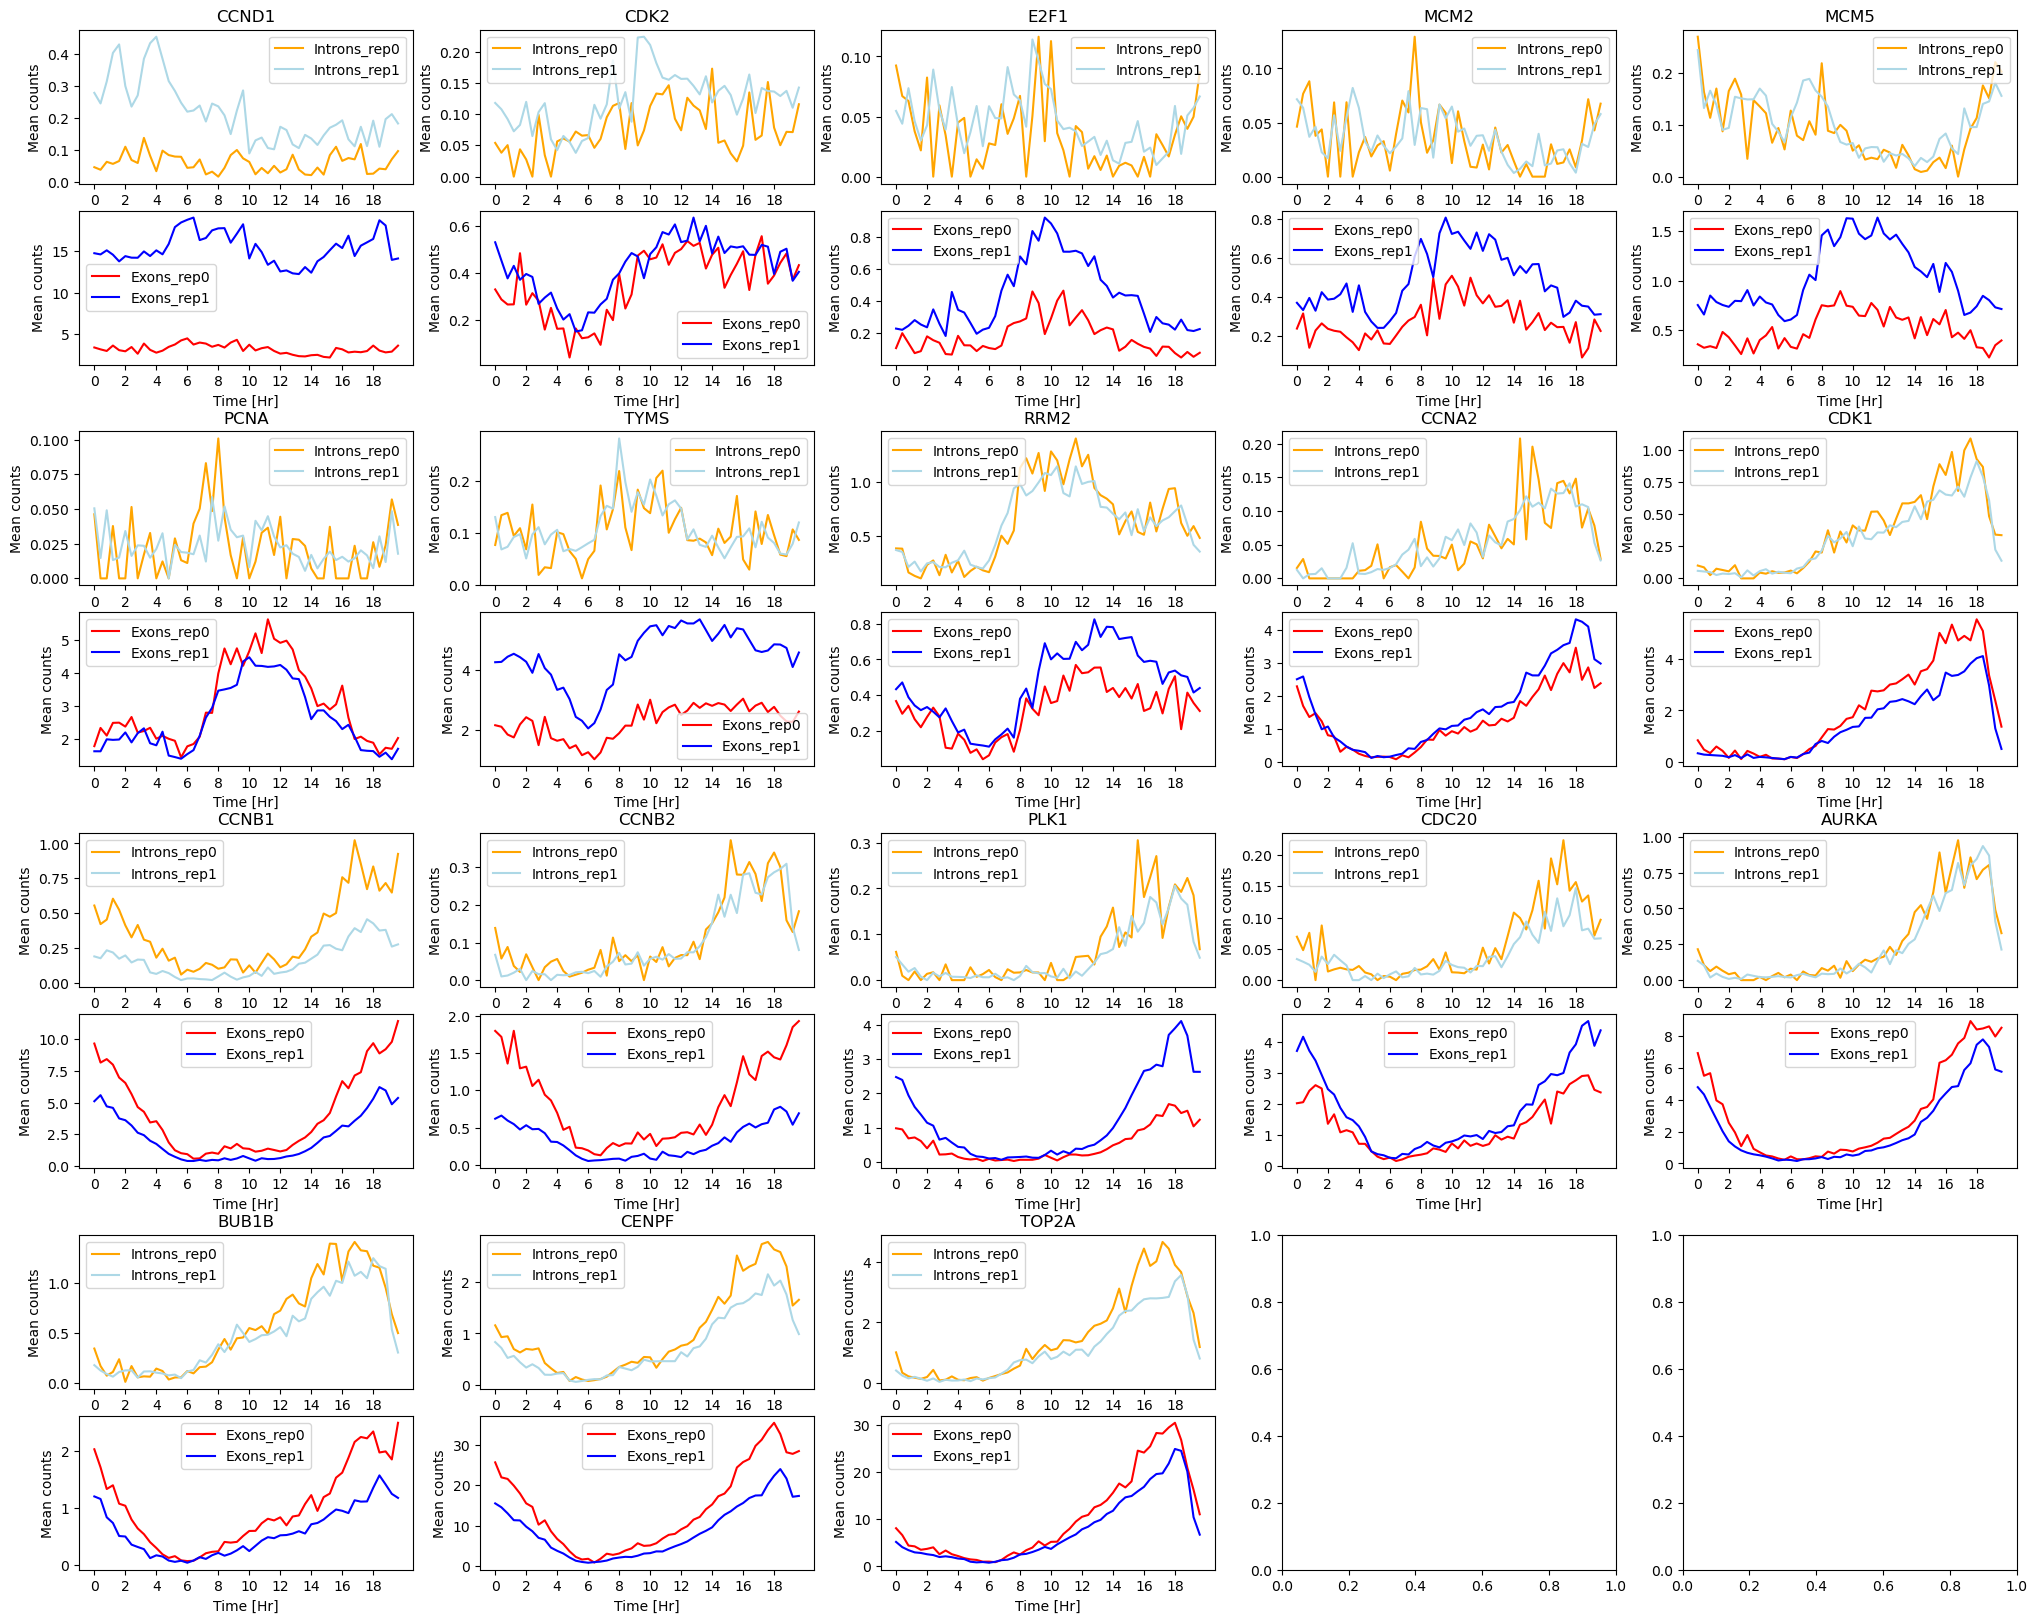

In [ ]:
# Answer 1.1


# List of 18–20 well-known human cell-cycle genes
your_genes_list = [
    # G1 / early G1/S
    "CCND1",  
    "CDK2",
    "E2F1",

    # G1/S and S-phase (DNA replication)
    "CCNE1",  
    "MCM2", "MCM5",
    "PCNA",
    "TYMS",
    "RRM2",

    # S/G2 and G2
    "CCNA2",  
    "CDK1",

    # G2/M and mitosis
    "CCNB1", "CCNB2",   
    "PLK1",
    "CDC20",
    "AURKA",
    "BUB1B",
    "CENPF",
    "TOP2A"
]

# Keep only genes that are actually present in the dataset
genes_present = [g for g in your_genes_list if g in dat.index]
print("Genes present in dataset:", len(genes_present), " / ", len(your_genes_list))
print(genes_present)



plot_gene_list(dat, genes_present)




In [22]:

# Answer 1.2

def run_PCA_2D(data, title, color_by='time', symbol_by='replicate',
               offset=0.1, scale_data=True, std_div=True):
    """
    Simple PCA: show only PC1 vs PC2 in a single panel.
    """
    data_tmp = data.copy()
    X = np.log2(data + offset).to_numpy()

    # same scaling as in run_PCA
    if scale_data:
        X[:, :50] = X[:, :50] - X[:, :50].mean(1).reshape(-1, 1)
        X[:, 50:] = X[:, 50:] - X[:, 50:].mean(1).reshape(-1, 1)
        if std_div:
            X[:, :50] = X[:, :50] / X[:, :50].std(1).reshape(-1, 1)
            X[:, 50:] = X[:, 50:] / X[:, 50:].std(1).reshape(-1, 1)

    pca = PCA(n_components=2)
    pca_scores = pca.fit_transform(X.T)

    pca_df = pd.DataFrame(pca_scores, columns=["PC1", "PC2"])
    pca_df[color_by] = data_tmp.columns.get_level_values(color_by)
    pca_df[symbol_by] = data_tmp.columns.get_level_values(symbol_by)

    if color_by == "time":
        pca_df[color_by] = np.round(
            pd.to_numeric(data_tmp.columns.get_level_values(color_by))/50 * 20,
            1
        ).astype(str)
        palette = "twilight"
    else:
        palette = "Set1"

    plt.figure(figsize=(7, 6))
    sns.scatterplot(
        data=pca_df,
        x="PC1", y="PC2",
        hue=color_by,
        style=symbol_by,
        s=120,
        palette=palette,
    )
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
    plt.title(title)
    plt.gca().set_box_aspect(1)
    plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), title=color_by)
    plt.tight_layout()
    plt.show()

PCA on EXONS (curated gene list)


C:\Users\sophi\AppData\Local\Temp\ipykernel_33928\3403548229.py:49: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


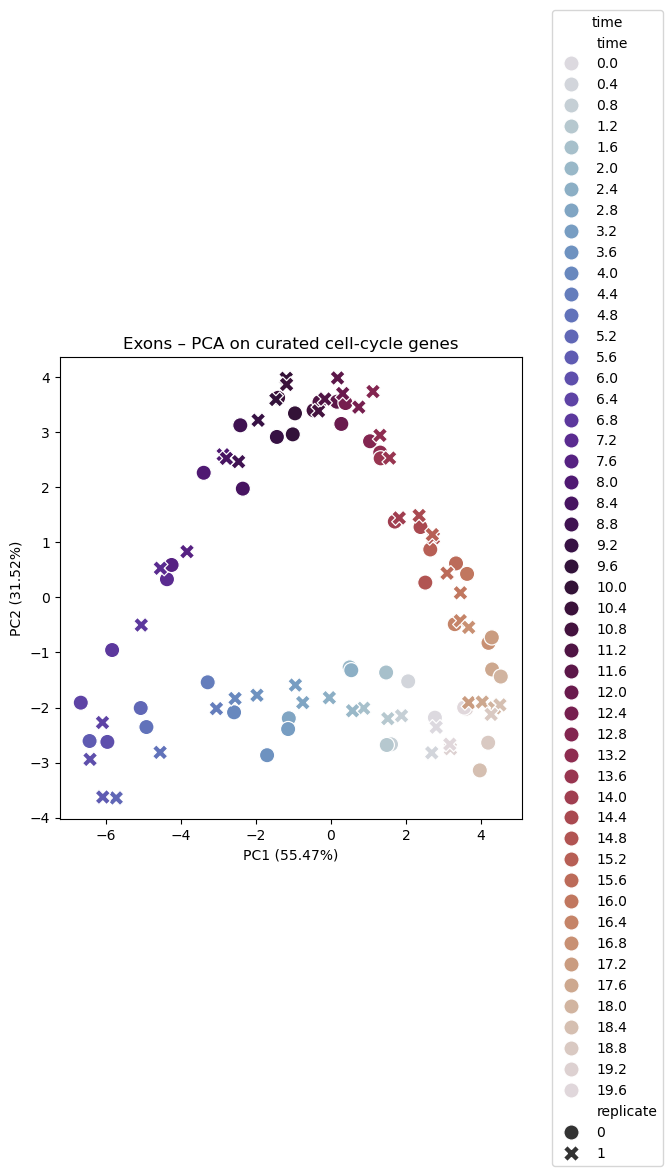

PCA on INTRONS (curated gene list)


C:\Users\sophi\AppData\Local\Temp\ipykernel_33928\3403548229.py:49: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


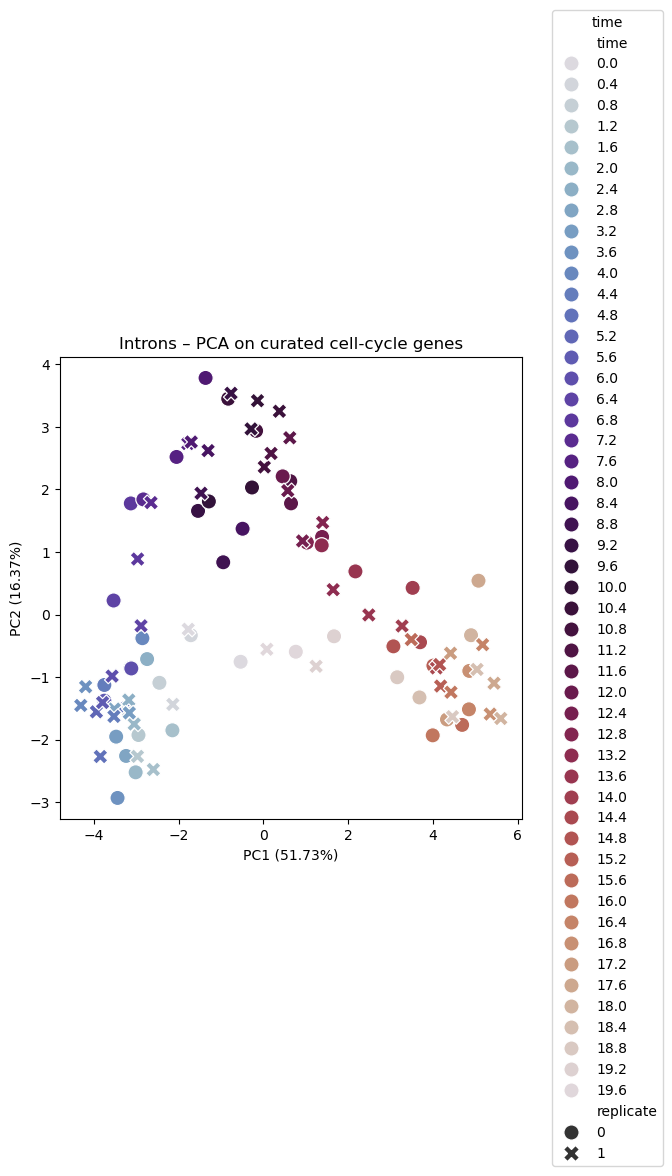

In [23]:
print("PCA on EXONS (curated gene list)")
run_PCA_2D(
    dat_exon.loc[genes_present],
    title="Exons – PCA on curated cell-cycle genes",
    color_by="time",
    symbol_by="replicate"
)

print("PCA on INTRONS (curated gene list)")
run_PCA_2D(
    dat_intron.loc[genes_present],
    title="Introns – PCA on curated cell-cycle genes",
    color_by="time",
    symbol_by="replicate"
)

##### Answer 1.3

Based on the gene expression time-course and PCA plots of curated cell cycle genes, we can estimate when the key cell cycle transitions occur. The **G₁/S transition**, marking the onset of DNA replication, is indicated by sharp increases in the expression of genes such as *PCNA*, *CDK2*, and *MCM2*—these peaks occur around 6–8 hours after synchronization, consistent with a commitment to S phase reported in literature. On the PCA plots, this transition aligns with an inflection where samples move from the early phase cluster towards a distinct trajectory, reflecting the shift in global gene expression. The **G₂/M transition** is marked by a rapid rise in expression of mitotic genes like *CCNB1*, *PLK1*, and *AURKA*, which reach their peaks around 15–17 hours. This phase is also represented as another turn along the PCA trajectory, where late samples diverge further, reflecting preparation for mitosis. Thus, inspection of both the gene-level profiles and the global patterns in PCA allows us to estimate that G₁/S and G₂/M transitions occur at approximately 6–8 hours and 15–17 hours, respectively.

---

References :
Georgi, A. B., Stukenberg, P. T., & Kirschner, M. W. (2002). Timing of events in mitosis. Current biology : CB, 12(2), 105–114. https://doi.org/10.1016/s0960-9822(01)00662-5
https://www.nature.com/scitable/topicpage/the-domino-and-clock-models-of-cell-14233440/

#### Assess gene expression periodicity genome-wide

In [24]:
# Apply the function to both intron and exon data.
offset=0.1
dat_intron_fit=dat_intron
dat_exon_fit=dat_exon
dat_intron_fit = np.log2(dat_intron_fit + offset)
dat_exon_fit = np.log2(dat_exon_fit + offset)

T = 20
time = dat_exon_fit.columns.get_level_values('time').str.replace('ZT','').astype(int).to_numpy()
time=time/(time.max()+1)
time=time*T

results_intron = fit_harmo(dat_intron_fit, time, T)
results_exon = fit_harmo(dat_exon_fit, time, T)



#### Define the genes of interest

In [30]:
# Get the genes with significant periodic gene expression in introns and exons
#genes_per_introns = np.logical_and(..., ...)


# Answer 1.4.1

q_thresh = 0.05
amp_thresh_intron = 0.5   # log2 peak-to-trough > 0.5 for introns
amp_thresh_exon   = 0.25  # log2 peak-to-trough > 0.25 for exons

mask_intron = (results_intron["q_val"] < q_thresh) & \
              (results_intron["amp"]   > amp_thresh_intron)

mask_exon   = (results_exon["q_val"]   < q_thresh) & \
              (results_exon["amp"]     > amp_thresh_exon)

genes_per_introns = results_intron[mask_intron]
genes_per_exons   = results_exon[mask_exon]

print("Number of periodic intron genes:", genes_per_introns.shape[0])
print("Number of periodic exon genes:",   genes_per_exons.shape[0])

genes_per_introns.sort_values("amp", ascending=False).head(10)
genes_per_exons.sort_values("amp", ascending=False).head(10)


Number of periodic intron genes: 1233
Number of periodic exon genes: 3016


,mu,amp,phase,p_val,q_val
HIST1H1B,-0.732161,4.824483,12.506916,3.454580e-52,5.148707e-49
AURKA,0.718646,4.192075,17.462674,3.800085e-56,1.415912e-52
HIST1H4C,4.463438,4.089638,12.900956,4.644678e-60,3.461214e-56
TOP2A,2.511067,3.941449,15.776008,2.848882e-54,7.076624e-51
CDK1,0.219460,3.935738,14.558418,3.745269e-43,8.208749e-41
CDCA8,-0.216391,3.862694,16.464445,1.294072e-41,1.928685e-39
CENPE,0.952764,3.830449,17.140305,6.890721e-49,3.949973e-46
HJURP,-0.562977,3.818015,15.756934,7.993864e-42,1.241047e-39
ASPM,0.721554,3.768879,17.258091,1.006630e-52,1.875351e-49
SGO2,0.146639,3.704199,17.209519,3.219966e-45,1.137536e-42


#### Plot phase and amplitude distribution for the rhythmic genes

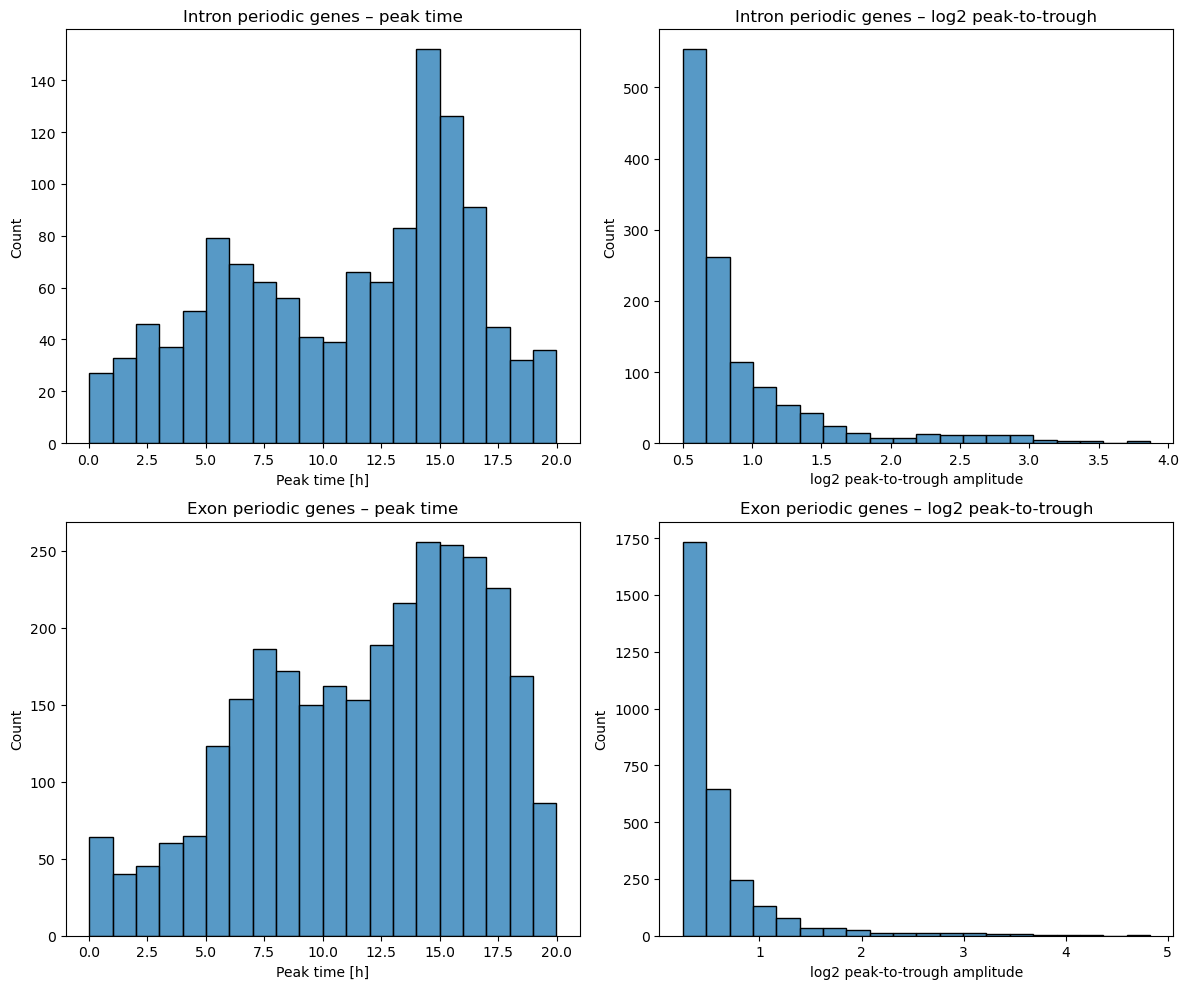

In [29]:
# Answer 1.4.2

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Intron – phase
sns.histplot(genes_per_introns["phase"], bins=20, ax=axs[0, 0])
axs[0, 0].set_title("Intron periodic genes – peak time")
axs[0, 0].set_xlabel("Peak time [h]")
axs[0, 0].set_ylabel("Count")

# Intron – amplitude
sns.histplot(genes_per_introns["amp"], bins=20, ax=axs[0, 1])
axs[0, 1].set_title("Intron periodic genes – log2 peak-to-trough")
axs[0, 1].set_xlabel("log2 peak-to-trough amplitude")
axs[0, 1].set_ylabel("Count")

# Exon – phase
sns.histplot(genes_per_exons["phase"], bins=20, ax=axs[1, 0])
axs[1, 0].set_title("Exon periodic genes – peak time")
axs[1, 0].set_xlabel("Peak time [h]")
axs[1, 0].set_ylabel("Count")

# Exon – amplitude
sns.histplot(genes_per_exons["amp"], bins=20, ax=axs[1, 1])
axs[1, 1].set_title("Exon periodic genes – log2 peak-to-trough")
axs[1, 1].set_xlabel("log2 peak-to-trough amplitude")
axs[1, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()


##### Answer 1.4
Applying q-value and amplitude thresholds allows selection of genes with robust periodic behavior throughout the cell cycle. Histograms of peak times (phase) reveal a clear temporal pattern: both intron and exon periodic genes show broad distributions, but pronounced peaks emerge between 12–18 hours, corresponding to late cell cycle phases such as G2 and M. This indicates that a substantial fraction of cell cycle–regulated genes reach maximum expression during mitosis. In contrast, fewer genes peak during G1 or G1/S, implying tighter temporal clustering of mitotic transcriptional activity. Similarly, amplitude histograms show most selected genes exhibit moderate log₂ peak-to-trough values, with only a minority displaying very strong rhythmicity. These findings collectively reveal that, among periodically expressed genes, there is significant enrichment for late phase expression, highlighting the orchestrated and temporally discrete nature of cell cycle transcriptional activation.


#### Investigate the types of genes that were selected as periodic

In [28]:
# Answer 1.5

# Get lists of gene names
periodic_intron_genes = genes_per_introns.index.tolist()
periodic_exon_genes   = genes_per_exons.index.tolist()

print("Example periodic intron genes:")
print(genes_per_introns.sort_values("amp", ascending=False).head(30).index.tolist())

print("\nExample periodic exon genes:")
print(genes_per_exons.sort_values("amp", ascending=False).head(30).index.tolist())

# Overlap with our curated list 
curated_set = set(your_genes_list)
overlap_intron = sorted(curated_set & set(periodic_intron_genes))
overlap_exon   = sorted(curated_set & set(periodic_exon_genes))
not_recovered  = sorted(curated_set - (set(overlap_intron) | set(overlap_exon)))

print("\nCurated genes periodic in INTRONS:")
print(overlap_intron)

print("\nCurated genes periodic in EXONS:")
print(overlap_exon)

print("\nCurated genes NOT recovered as periodic with our thresholds:")
print(not_recovered)


Example periodic intron genes:
['TOP2A', 'CIT', 'CENPE', 'KIF14', 'KIF18B', 'KIF4A', 'ASPM', 'KIF2C', 'CDCA8', 'RGS3', 'KNL1', 'GAS2L3', 'CDC25C', 'CENPF', 'CKAP2', 'CCNF', 'NDC80', 'NUF2', 'TPX2', 'GTSE1', 'KIF20B', 'KIF23', 'ANLN', 'CEP55', 'KIF11', 'CDCA2', 'SPC25', 'RACGAP1', 'BUB1B', 'KPNA2']

Example periodic exon genes:
['HIST1H1B', 'AURKA', 'HIST1H4C', 'TOP2A', 'CDK1', 'CDCA8', 'CENPE', 'HJURP', 'ASPM', 'SGO2', 'KIF2C', 'PLK1', 'NUF2', 'KIF14', 'CENPF', 'NDC80', 'KIF23', 'MKI67', 'FAM83D', 'CKAP2', 'HIST1H1C', 'CCNB1', 'GTSE1', 'KIF11', 'TTK', 'GAS2L3', 'UBE2C', 'CCNA2', 'HMGB2', 'HMMR']

Curated genes periodic in INTRONS:
['AURKA', 'BUB1B', 'CCNA2', 'CCNB1', 'CCNB2', 'CCND1', 'CDC20', 'CDK1', 'CDK2', 'CENPF', 'MCM5', 'PLK1', 'RRM2', 'TOP2A']

Curated genes periodic in EXONS:
['AURKA', 'BUB1B', 'CCNA2', 'CCNB1', 'CCNB2', 'CDC20', 'CDK1', 'CDK2', 'CENPF', 'E2F1', 'MCM2', 'MCM5', 'PCNA', 'PLK1', 'RRM2', 'TOP2A', 'TYMS']

Curated genes NOT recovered as periodic with our thresholds

##### Answer 1.5

The list of periodic genes identified in the cell cycle dataset includes several major categories: cyclins (such as *CCND1*, *CCNB1*, *CCNB2*, *CCNA2*), cyclin-dependent kinases (*CDK1*, *CDK2*), DNA replication factors (*MCM2*, *MCM5*, *PCNA*, *TYMS*, *RRM2*), mitotic regulators (*PLK1*, *CDC20*, *AURKA*, *BUB1B*), and proteins involved in chromosome organization and segregation (*CENPF*, *TOP2A*, *E2F1*). These genes play essential roles in driving cell cycle progression through G1, S, G2, and M phases, ensuring orderly DNA replication, checkpoint control, and mitosis

When comparing the periodic genes identified by the analysis to the list of well-known cell-cycle genes curated in step 1, the dataset successfully recovers 18 out of 19 designed targets: all except *CCNE1*. This means the method reliably captures nearly all principal cell cycle regulators with strong periodic expression, demonstrating its effectiveness in covering the major biological events and transitions of the cell cycle with high specificity.



### Question 2

1. Related to Exercise 1, study the relationship between the peak times (i.e., phase) of pre-mRNA and mRNA for genes that exhibit periodic behaviour at both the pre-mRNA and mRNA levels. Use appropriate cutoffs in your analysis to select a subset of genes that are periodic at both the pre-mRNA and mRNA levels. Aim to include several hundred genes for a robust analysis.  
   **Hint:** Show a scatter plot of mRNA vs. pre-mRNA peak times. Explain your findings.

2. Show representative profiles of genes with short or long delays between the pre-mRNA and mRNA peak times. Explain.

3. From the delay between the pre-mRNA and mRNA ($\delta t$ [hr]), infer the mRNA half-life ($\tau$ [hr]) using the formula derived in the course:  


   $$\tan\left(\frac{2\pi \cdot \delta t}{20}\right) = \frac{2\pi}{20}  \frac{ \tau}{\ln(2)}$$
 

   Plot the histogram of the inferred mRNA half-lives and a scatter plot of half life vs mRNA amplitudes ($log_2$ peak-to-trough). Explain your findings.

4. **(Bonus):** What can you infer about the splicing rate?  





#### Plot pre-mRNA, mRNA delay

In [13]:
#plot phase exons vs phase introns
#...
#...


### Plot representative genes with short or long-delay

In [14]:
#Compute the delay between intron and exon
#Restrict to genes with phase difference < 5 hours and with exon later than intron

#...
#...
#...
#...

#find genes with short delay, plot representative gene expression
#plot_gene_expression(dat_melted, "GeneName")


#find gene with long delay between 3 and 5 hours
 #plot_gene_expression(dat_melted, "GeneName")


### Compute half-life from the delay between intron and exon


In [15]:
#...
#...
#...
#...

#### Compare Half lives and mRNA amplitudes

In [16]:
#...
#...
#...
#...